In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam



# Dataset

In [4]:
fp = "./features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset

,policy,barcode,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
0,3_6C-80PER_3_6C,???,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
1,3_6C-80PER_3_6C,???,1178.0,1.075301,0.009288,1.080630,-1.958457,-2.387257,-5.013960,-0.367163,0.012464,-3.803325,0.000006,1.080945,-0.000041,1.084710,-5.017121
2,3_6C-80PER_3_6C,???,1176.0,1.079922,0.008131,1.084940,-1.764058,-2.348070,-4.737000,0.033502,-0.457627,-5.056484,0.000011,1.084826,-0.000044,1.089331,-4.734378
3,4C-80PER_4C,???,1225.0,1.079723,0.006530,1.084750,-1.722149,-2.127507,-4.442613,-0.357486,0.039579,-3.739833,0.000018,1.084053,-0.000003,1.085031,-4.438865
4,4C-80PER_4C,???,1226.0,1.078417,0.005900,1.082646,-1.855177,-2.240332,-4.647744,-0.440634,0.125101,-4.380559,0.000020,1.081850,-0.000033,1.085851,-4.642574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6C_31PER_4_25C,???,462.0,1.073565,0.007075,1.079078,-1.226029,-1.547619,-3.394968,-1.993884,0.134112,-4.417652,0.000013,1.078951,-0.000031,1.082138,-3.391890
76,6C_40PER_4C,???,457.0,1.070887,0.006366,1.076360,-1.244632,-1.577172,-3.452581,-1.389835,0.111612,-4.012170,0.000023,1.075190,-0.000017,1.078153,-3.453071
77,6C_4PER_4_75C,???,487.0,1.070473,0.005186,1.073041,-1.361351,-1.680775,-3.688418,-1.539699,0.113010,-4.279524,-0.000006,1.074844,-0.000079,1.080819,-3.691468
78,6C_52PER_3_5C,???,429.0,1.072614,0.007384,1.079520,-1.219913,-1.521692,-3.368943,-1.205534,0.132095,-4.142284,0.000030,1.077609,-0.000013,1.080783,-3.369759


In [5]:
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])
dataset

,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
0,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
1,1178.0,1.075301,0.009288,1.080630,-1.958457,-2.387257,-5.013960,-0.367163,0.012464,-3.803325,0.000006,1.080945,-0.000041,1.084710,-5.017121
2,1176.0,1.079922,0.008131,1.084940,-1.764058,-2.348070,-4.737000,0.033502,-0.457627,-5.056484,0.000011,1.084826,-0.000044,1.089331,-4.734378
3,1225.0,1.079723,0.006530,1.084750,-1.722149,-2.127507,-4.442613,-0.357486,0.039579,-3.739833,0.000018,1.084053,-0.000003,1.085031,-4.438865
4,1226.0,1.078417,0.005900,1.082646,-1.855177,-2.240332,-4.647744,-0.440634,0.125101,-4.380559,0.000020,1.081850,-0.000033,1.085851,-4.642574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,462.0,1.073565,0.007075,1.079078,-1.226029,-1.547619,-3.394968,-1.993884,0.134112,-4.417652,0.000013,1.078951,-0.000031,1.082138,-3.391890
76,457.0,1.070887,0.006366,1.076360,-1.244632,-1.577172,-3.452581,-1.389835,0.111612,-4.012170,0.000023,1.075190,-0.000017,1.078153,-3.453071
77,487.0,1.070473,0.005186,1.073041,-1.361351,-1.680775,-3.688418,-1.539699,0.113010,-4.279524,-0.000006,1.074844,-0.000079,1.080819,-3.691468
78,429.0,1.072614,0.007384,1.079520,-1.219913,-1.521692,-3.368943,-1.205534,0.132095,-4.142284,0.000030,1.077609,-0.000013,1.080783,-3.369759


In [6]:
# feat = dataset.loc[:,'QDiffLinVar'].to_numpy()
# bat_info = dataset.loc[:,'policy':'cycle_life']


## Split Train-Test

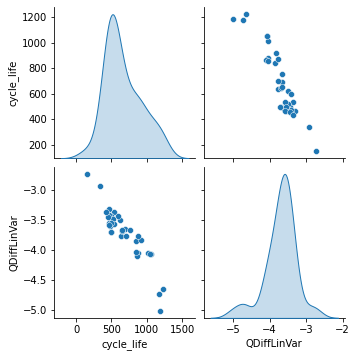

In [7]:
train_dataset = dataset.iloc[0::2, :]
test_dataset = dataset.iloc[1::2, :]
sns.pairplot(train_dataset[['cycle_life', 'QDiffLinVar']], diag_kind='kde')

In [8]:
# train_dataset = feat[0::2]
# test_dataset = feat[1::2]
# label_train = bat_info["cycle_life"][0::2]
# label_test = bat_info["cycle_life"][1::2]

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle_life,40.0,661.900000,253.542370,148.000000,480.750000,566.500000,855.000000,1226.000000
QD2,40.0,1.074524,0.007838,1.048037,1.070504,1.074543,1.079108,1.094639
QD(Max-2),40.0,0.062221,0.293979,0.001546,0.004442,0.005628,0.006416,1.817914
QD100,40.0,1.073757,0.020363,0.968339,1.073190,1.077058,1.082280,1.095349
QDiffMin,40.0,-1.367683,0.210507,-2.072648,-1.436441,-1.336577,-1.242969,-0.860038
QDiffMean,40.0,-1.716718,0.254903,-2.541602,-1.799940,-1.683338,-1.600772,-1.109668
QDiffVar,40.0,-3.704868,0.424797,-5.014861,-3.842137,-3.627437,-3.480982,-2.726901
QDiffSkew,40.0,-0.797872,0.372961,-1.500458,-1.066717,-0.848007,-0.534206,0.033502
QDiffKurtosis,40.0,0.076688,0.109324,-0.457627,0.090105,0.103363,0.116203,0.132095
QDiffStart,40.0,-4.236484,0.498418,-5.440747,-4.540804,-4.182197,-3.829733,-3.523679


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cycle_life')
test_labels = test_features.pop('cycle_life')
train_features

,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-2.102467e-04,1.091262,0.000039,1.072078,-5.013791
2,1.079922,0.008131,1.084940,-1.764058,-2.348070,-4.737000,0.033502,-0.457627,-5.056484,1.088596e-05,1.084826,-0.000044,1.089331,-4.734378
4,1.078417,0.005900,1.082646,-1.855177,-2.240332,-4.647744,-0.440634,0.125101,-4.380559,1.970664e-05,1.081850,-0.000033,1.085851,-4.642574
6,1.075836,0.006303,1.079243,-1.421521,-1.796830,-3.768878,-0.389408,0.092745,-4.207368,-3.903811e-06,1.081126,-0.000061,1.085331,-3.767264
8,1.082974,0.005976,1.087631,-1.541748,-1.938902,-4.059384,-0.368971,0.072680,-4.424570,1.881074e-05,1.086751,-0.000012,1.088857,-4.059990
10,1.070966,0.006878,1.076202,-1.548306,-1.922770,-4.046070,-0.549054,0.118360,-4.596108,2.698320e-05,1.074739,-0.000020,1.078194,-4.044825
12,1.081166,0.007425,1.086321,-1.558986,-1.906445,-4.099414,-0.910272,0.089233,-3.762297,2.397059e-05,1.085261,-0.000032,1.089492,-4.102170
14,1.066170,1.817914,1.064527,-1.355234,-1.683980,-3.650081,-1.283338,0.129215,-4.422620,-2.898182e-04,1.101303,-0.000117,1.076054,-3.652997
16,1.072630,0.003094,1.061248,-1.196677,-1.484179,-3.367237,-0.616772,0.030487,-5.440747,-1.386752e-04,1.076932,-0.000231,1.084364,-3.363854
18,1.079293,0.004493,1.081691,-1.523552,-1.874824,-4.040794,-0.844135,0.090119,-3.819883,-6.679779e-06,1.082806,-0.000020,1.083696,-4.043615


## Normalization Layer

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-07-08 19:35:19.304270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[ 1.0745237e+00  6.2220503e-02  1.0737574e+00 -1.3676827e+00
  -1.7167178e+00 -3.7048676e+00 -7.9787225e-01  7.6688468e-02
  -4.2364841e+00 -5.2411451e-05  1.0802388e+00 -9.6687763e-05
   1.0834242e+00 -3.7046471e+00]]


## Linear Regression

### Layering

In [12]:
QDiffLinVar = np.array(train_features['QDiffLinVar'])

QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

### Model

In [13]:
variance_model = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

variance_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


This model predicts cyclelife from QDiffVariance

In [14]:
variance_model.predict(QDiffLinVar[:10])

array([[0.05318057],
       [0.04183017],
       [0.03810085],
       [0.00254367],
       [0.01443491],
       [0.01381881],
       [0.01614835],
       [0.00570898],
       [0.03766834],
       [0.01376969]], dtype=float32)

In [15]:
variance_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
    )

In [16]:
%%time
history = variance_model.fit(
    train_features['QDiffLinVar'],
    train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/1000
1/1 - 1s - loss: 567211.0000 - mae: 706.4457 - val_loss: 234797.0312 - val_mae: 483.4311 - 822ms/epoch - 822ms/step
Epoch 2/1000
1/1 - 0s - loss: 566757.3750 - mae: 706.1597 - val_loss: 234633.5625 - val_mae: 483.2604 - 38ms/epoch - 38ms/step
Epoch 3/1000
1/1 - 0s - loss: 566310.6250 - mae: 705.8795 - val_loss: 234444.0312 - val_mae: 483.0628 - 29ms/epoch - 29ms/step
Epoch 4/1000
1/1 - 0s - loss: 565804.6250 - mae: 705.5618 - val_loss: 234224.6094 - val_mae: 482.8340 - 28ms/epoch - 28ms/step
Epoch 5/1000
1/1 - 0s - loss: 565201.6250 - mae: 705.1847 - val_loss: 233965.3125 - val_mae: 482.5637 - 32ms/epoch - 32ms/step
Epoch 6/1000
1/1 - 0s - loss: 564473.7500 - mae: 704.7313 - val_loss: 233656.3281 - val_mae: 482.2416 - 46ms/epoch - 46ms/step
Epoch 7/1000
1/1 - 0s - loss: 563596.5000 - mae: 704.1862 - val_loss: 233290.5312 - val_mae: 481.8602 - 31ms/epoch - 31ms/step
Epoch 8/1000
1/1 - 0s - loss: 562549.1875 - mae: 703.5365 - val_loss: 232855.8594 - val_mae: 481.4069 - 30ms/

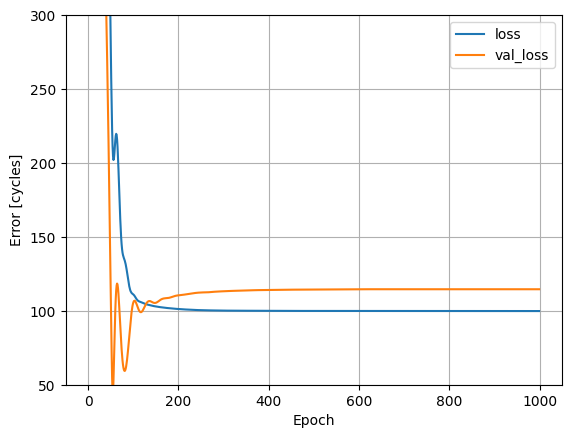

In [17]:
def plot_loss(history):
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  # plt.ylim([200, 130])
  plt.ylim([50, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [18]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist


,loss,mae,val_loss,val_mae,epoch
0,753.134118,26.579047,484.558594,21.987066,0
1,752.832900,26.573666,484.389887,21.983185,1
2,752.536129,26.568393,484.194208,21.978689,2
3,752.199857,26.562414,483.967571,21.973484,3
4,751.798926,26.555314,483.699610,21.967332,4
...,...,...,...,...,...
995,99.837324,8.992388,114.574365,10.308569,995
996,99.837226,8.992379,114.574548,10.308579,996
997,99.837162,8.992373,114.574744,10.308590,997
998,99.837094,8.992366,114.576505,10.308692,998


In [19]:
test_results = {}

test_results['variance_model'] = variance_model.evaluate(
    test_features['QDiffLinVar'],
    test_labels, verbose=0) #sqrt for mse

In [20]:
x = tf.linspace(-5, 2, 100)
y = variance_model.predict(x)

### Predict

In [21]:
def plot_prediction(y_train, y_test):
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

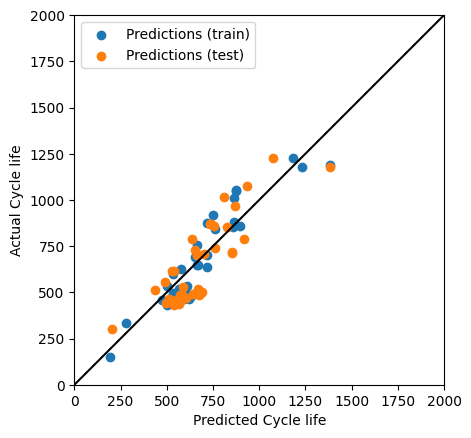

In [22]:
train_prediction = variance_model.predict(train_features['QDiffLinVar'])
test_prediction = variance_model.predict(test_features['QDiffLinVar'])

plot_prediction(train_prediction, test_prediction)

### Evaluate

In [23]:
test_results['variance_model'][0] = test_results['variance_model'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'Mean absolute error']).T

,MSE,Mean absolute error
variance_model,119.137013,108.066307


### Error Distribution

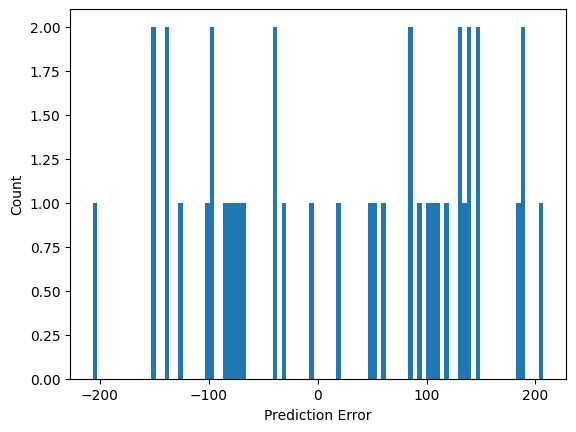

In [24]:
error = test_prediction.flatten() - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

# Transfer Learning